In [1]:
import numpy as np

## Runge-Kutta Methods, RK4

In [2]:
def ode_func(t, y):
    return t*y

In [3]:
def rk4(f, t0, y0, h, n):
    v = np.zeros(n+1)
    v[0] = y0
    t = t0
    y = y0

    for i in range(1, n+1):
        k1 = h*f(t, y)
        k2 = h*f(t + h/2, y + k1/2)
        k3 = h*f(t + h/2, y + k2/2)
        k4 = h*f(t + h, y + k3)

        v[i] = v[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
        t += h
        y = v[i]
    
    return v

In [4]:
def plot_integrator(v, t0, h):
    import matplotlib.pyplot as plt

    t = np.linspace(t0, t0 + h*len(v), len(v))
    plt.plot(t, v)
    plt.show()

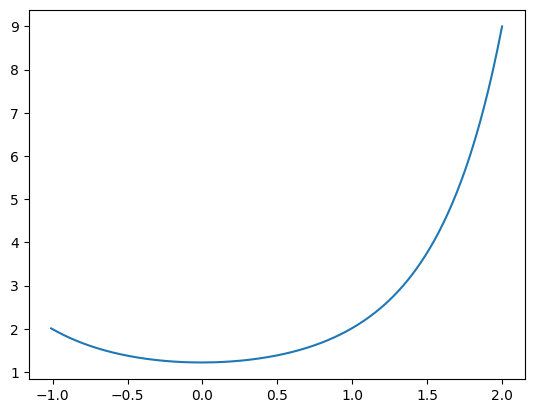

In [48]:
h = 0.01

v = rk4(ode_func, 2, 9, -h, 300)
plot_integrator(v, 2, -h)

## Solve ODE with Torchdiffeq

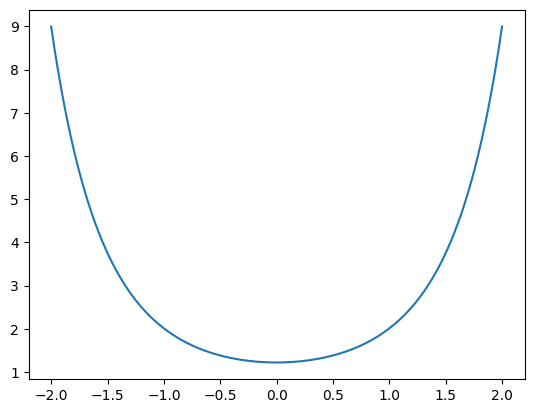

In [59]:
from torchdiffeq import odeint
import torch
import matplotlib.pyplot as plt

z0 = torch.Tensor([9])
t = torch.linspace(2, -2, 400)
out = odeint(ode_func, z0, t)

plt.plot(t, out)
plt.show()

## Another example of solving higher order DE

torch.Size([1000, 3])


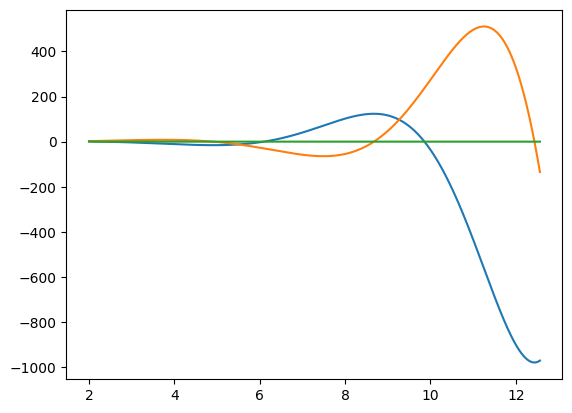

In [72]:
class SystemOfEquations:
    def __init__(self, km, p, g, r):
        self.mat = torch.Tensor([[0, 1, 0], [-km, p, 0], [0, g, -r]])

    def solve(self, t, x0, dx0, ddx0):
        y0 = torch.cat([x0, dx0, ddx0])
        out = odeint(self.func, y0, t)
        print(out.shape)
        return out

    def func(self, t, y):
        out = y@self.mat
        return out

x0 = torch.Tensor([1])
dx0 = torch.Tensor([2])
ddx0 = torch.Tensor([1])

t = torch.linspace(2, 4*np.pi, 1000)
solver = SystemOfEquations(1, 1.1, 5, 10)
out = solver.solve(t, x0, dx0, ddx0)

plt.plot(t, out)
plt.show()

## nonlinear pendulum equation

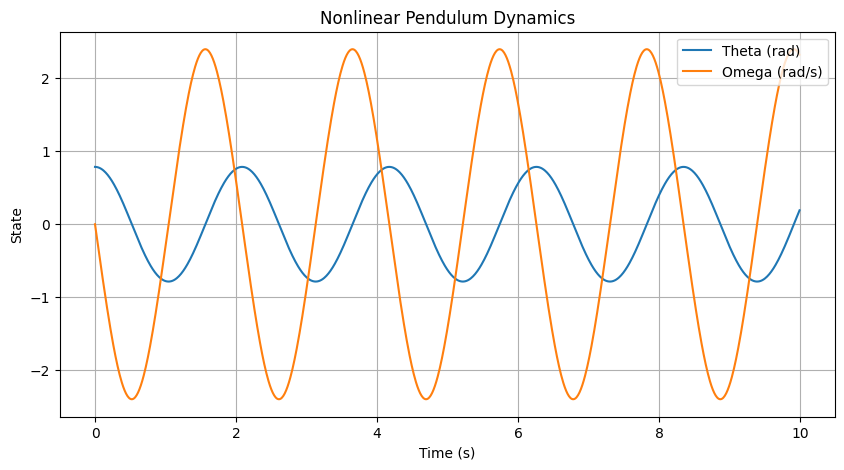

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def pendulum_derivatives(t, y, g=9.81, L=1.0):
    """ Compute the derivatives for the pendulum system.
        y = [theta, omega]
    """
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return np.array([dtheta_dt, domega_dt])

def rk4_step(y, t, dt, derivatives, *args):
    """ Perform a single RK4 step. """
    k1 = dt * derivatives(t, y, *args)
    k2 = dt * derivatives(t + dt/2, y + k1/2, *args)
    k3 = dt * derivatives(t + dt/2, y + k2/2, *args)
    k4 = dt * derivatives(t + dt, y + k3, *args)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

# Simulation parameters
t0 = 0
tf = 10
dt = 0.01
theta0 = np.pi / 4  # Initial angle (45 degrees)
omega0 = 0  # Initial angular velocity

# Time array
t_values = np.arange(t0, tf, dt)
y_values = np.zeros((len(t_values), 2))
y_values[0] = [theta0, omega0]

# RK4 integration
for i in range(1, len(t_values)):
    y_values[i] = rk4_step(y_values[i-1], t_values[i-1], dt, pendulum_derivatives)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_values, y_values[:, 0], label="Theta (rad)")
plt.plot(t_values, y_values[:, 1], label="Omega (rad/s)")
plt.title("Nonlinear Pendulum Dynamics")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()


## Neural ODE for Halfmoon Dataset Classification

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

In [12]:
class MoonDataset(data.Dataset):
    def __init__(self, n_samples=100, noise_std=1e-4):
        self.n_samples = n_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_data(n_samples, noise_std)

    def generate_data(self, n_samples, noise_std):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out

        theta_out = np.linspace(0, np.pi, n_samples_out)
        theta_in = np.linspace(0, np.pi, n_samples_in)

        outer_circ_x = np.cos(theta_out)
        outer_circ_y = np.sin(theta_out)

        inner_circ_x = 1 - np.cos(theta_in)
        inner_circ_y = 1 - np.sin(theta_in) - 0.5

        X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                       np.append(outer_circ_y, inner_circ_y)]).T
        y = np.hstack([np.zeros(n_samples_out), np.ones(n_samples_in)])

        if noise_std is not None:
            X += np.random.normal(scale=noise_std, size=X.shape)

        x = torch.from_numpy(X).float()
        y = torch.from_numpy(y).long()
        return x, y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
import torch
from torch.utils.data import DataLoader, random_split
from typing import List, Optional

def split_dataset(dataset_size: int, split_percentages: List[float]) -> List[int]:
    """Calculate sizes of each dataset split according to given percentages."""
    split_sizes = [int(pi * dataset_size) for pi in split_percentages]
    split_sizes[0] += dataset_size - sum(split_sizes)  # Adjust the first split to account for rounding
    return split_sizes

class ToyDataModule:
    def __init__(self, dataset_size: int, split_percentages: Optional[List[float]] = None):
        self.dataset_size = dataset_size
        if split_percentages is None:
            split_percentages = [0.8, 0.1, 0.1]  # Default split: 80% train, 10% validation, 10% test
        self.split_sizes = split_dataset(self.dataset_size, split_percentages)

    def setup(self):
        # This method should be overridden to initialize datasets
        pass

    def train_dataloader(self) -> DataLoader:
        train_loader = DataLoader(self.train_set, batch_size=len(self.train_set), shuffle=True)
        return train_loader

    def val_dataloader(self) -> DataLoader:
        val_loader = DataLoader(self.val_set, batch_size=len(self.val_set), shuffle=False)
        return val_loader

    def test_dataloader(self) -> DataLoader:
        test_loader = DataLoader(self.test_set, batch_size=len(self.test_set), shuffle=False)
        return test_loader

class HalfMoonsDataModule(ToyDataModule):
    def __init__(self, dataset_size: int, split_percentages: Optional[List[float]] = None):
        super().__init__(dataset_size, split_percentages)

    def setup(self):
        dataset = MoonDataset(n_samples=self.dataset_size, noise_std=1e-1)
        self.train_set, self.val_set, self.test_set = random_split(dataset, self.split_sizes)

# Example usage
data_module = HalfMoonsDataModule(1000)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print("Train set size:", len(data_module.train_set))
print("Validation set size:", len(data_module.val_set))
print("Test set size:", len(data_module.test_set))


Train set size: 800
Validation set size: 100
Test set size: 100


In [24]:
import torchdiffeq

class ODE_func(nn.Module):
    def __init__(self, module, autonomous=True):
        super(ODE_func, self).__init__()
        self.module = module
        self.autonomous = autonomous

    def forward(self, t, x):
        if not self.autonomous:
            x = torch.cat([torch.ones_like(x[:, [0]])*t, x], 1)
        return self.module(x)
        
class ODEBlock(nn.Module):
    def __init__(self, odefunc, solver: str='dopri5',
                 rtol: float=1e-4, atol: float=1e-4, adjoint: bool=True,
                 autonomous: bool=True):
        super(ODEBlock, self).__init__()
        self.odefunc = ODE_func(odefunc, autonomous)

        self.rtol = rtol
        self.atol = atol
        self.solver = solver
        self.use_adjoint = adjoint
        self.integration_time = torch.tensor([0, 1]).float()

    @property
    def ode_method(self):
        return torchdiffeq.odeint_adjoint if self.use_adjoint else torchdiffeq.odeint
    
    def forward(self, x, adjoint=True, integration_time=None):
        integration_time = integration_time if integration_time is not None else self.integration_time
        integration_time = integration_time.to(x.device)

        ode_method = torchdiffeq.odeint_adjoint if adjoint else torchdiffeq.odeint
        out = ode_method(
            self.odefunc, x, integration_time,
            rtol=self.rtol, atol=self.atol, method=self.solver
        )

        return out

In [31]:
import torch
import torch.nn as nn
from torchmetrics import Accuracy
from torch.optim import Adam
from torch.utils.data import DataLoader

adjoint = True
data_module = HalfMoonsDataModule(1000)
t_span = torch.linspace(0, 1, 2)
f = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 2))
model = ODEBlock(f, adjoint=adjoint)

# Training
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

class Learner(nn.Module):
    def __init__(self, model: nn.Module, t_span: torch.Tensor, learning_rate: float = 5e-3):
        super().__init__()
        self.model = model
        self.t_span = t_span
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=2, task="multiclass")
        self.optimizer = Adam(self.model.parameters(), lr=self.learning_rate)

    def forward(self, x):
        return self.model(x)

    def inference(self, x, time_span):
        return self.model(x, adjoint=False, integration_time=time_span)

    def inference_no_projection(self, x, time_span):
        return self.model.forward_no_projection(x, adjoint=False, integration_time=time_span)

    def train_step(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        y_pred = self(x)
        y_pred = y_pred[-1]  # Assuming model output includes trajectories
        loss = self.loss_fn(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def validate(self, dataloader):
        self.eval()
        total_loss = 0
        total_correct = 0
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to('cuda'), y.to('cuda')
                y_pred = self(x)
                y_pred = y_pred[-1]  # Assuming model output includes trajectories
                loss = self.loss_fn(y_pred, y)
                total_loss += loss.item()
                acc = self.accuracy(y_pred.softmax(dim=-1), y)
                total_correct += acc.item()
        avg_loss = total_loss / len(dataloader)
        avg_acc = total_correct / len(dataloader)
        return avg_loss, avg_acc

    def test(self, dataloader):
        return self.validate(dataloader)

# Example usage:
# Define `model`, `t_span`, and `dataset`
learner = Learner(model, t_span).to('cuda')
for epoch in range(200):
    for x, y in train_loader:
        x, y = x.to('cuda'), y.to('cuda')
        loss = learner.train_step(x, y)
    val_loss, val_acc = learner.validate(val_loader)
    print(f'Epoch {epoch}, Validation Loss: {val_loss}, Accuracy: {val_acc}')


Epoch 0, Validation Loss: 1.2817384004592896, Accuracy: 0.18000000715255737
Epoch 1, Validation Loss: 1.1856002807617188, Accuracy: 0.18000000715255737
Epoch 2, Validation Loss: 1.1053742170333862, Accuracy: 0.1899999976158142
Epoch 3, Validation Loss: 1.0388586521148682, Accuracy: 0.18000000715255737
Epoch 4, Validation Loss: 0.9838690757751465, Accuracy: 0.1899999976158142
Epoch 5, Validation Loss: 0.9384203553199768, Accuracy: 0.18000000715255737
Epoch 6, Validation Loss: 0.9008010625839233, Accuracy: 0.18000000715255737
Epoch 7, Validation Loss: 0.8695834279060364, Accuracy: 0.18000000715255737
Epoch 8, Validation Loss: 0.8435889482498169, Accuracy: 0.18000000715255737
Epoch 9, Validation Loss: 0.8218430280685425, Accuracy: 0.17000000178813934
Epoch 10, Validation Loss: 0.8035858273506165, Accuracy: 0.17000000178813934
Epoch 11, Validation Loss: 0.7881991863250732, Accuracy: 0.17000000178813934
Epoch 12, Validation Loss: 0.7751391530036926, Accuracy: 0.14000000059604645
Epoch 13, V

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@torch.no_grad()
def run_inference(learner, data_loader, time_span):
    learner.to(device)
    trajectories = []
    classes = []
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

time_span = np.linspace(0.0, 1.0, 100)
trajectories, classes = run_inference(learner, data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

In [37]:
def plot_binary_classification_dataset(X, y, title=None):
    CLASS_COLORS = ['coral', 'darkviolet']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], color=[CLASS_COLORS[yi.int()] for yi in y], alpha=0.6)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)

    return fig, ax

In [43]:
#@title You can omit reading this piece of code.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_trajectories(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(12,6))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    for i in range(trajectories.shape[1]):
        ax0.plot(time_span, trajectories[:, i, 0], color=class_colors[i], alpha=0.1)
        ax1.plot(time_span, trajectories[:, i, 1], color=class_colors[i], alpha=0.1)

    ax0.set_xlabel(r"$t$ [Depth]")
    ax0.set_ylabel(r"$\mathbf{z}_0(t)$")
    ax0.set_title("Dimension 0")
    ax1.set_xlabel(r"$t$ [Depth]")
    ax1.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax1.set_title("Dimension 1")


def plot_trajectories_3d(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], time_span,
                color=class_colors[i], alpha=0.1)

    ax.set_title('3D Trajectories')
    ax.set_xlabel(r"$\mathbf{z}_0(t)$")
    ax.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax.set_zlabel(r"$t$")


def plot_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_augmented_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        ax.set_title('Trajectories')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")
        ax.set_zlabel(r"$\mathbf{z}_2(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1], trajectories[t, zero_classes, 2],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1], trajectories[t, one_classes, 2],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


def plot_augmented_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], trajectories[:, i, 2],
                color=class_colors[i], alpha=0.1)

    ax.set_title('State-Space Diagram')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$z$")


def plot_static_vector_field(model, trajectory, N=50, device='cpu', ax=None):
    X, Y = np.mgrid[trajectory[..., 0].min():trajectory[..., 0].max():N*1j,
                    trajectory[..., 1].min():trajectory[..., 1].max():N*1j]
    X = X.T
    Y = Y.T
    P = np.vstack([X.ravel(), Y.ravel()]).T
    P = torch.Tensor(P).to(device)

    with torch.no_grad():
        vector_field = model.odefunc(0.0, P).cpu()
    vector_norm = vector_field.norm(dim=1).view(N, N).numpy()

    vector_field = vector_field.view(N, N, 2).numpy()

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
    ax.contourf(X, Y, vector_norm, cmap='RdYlBu')
    ax.streamplot(X, Y, vector_field[:, :, 0], vector_field[:, :, 1], color='k')

    ax.set_xlim([X.min(), X.max()])
    ax.set_ylim([Y.min(), Y.max()])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title("Learned Vector Field")

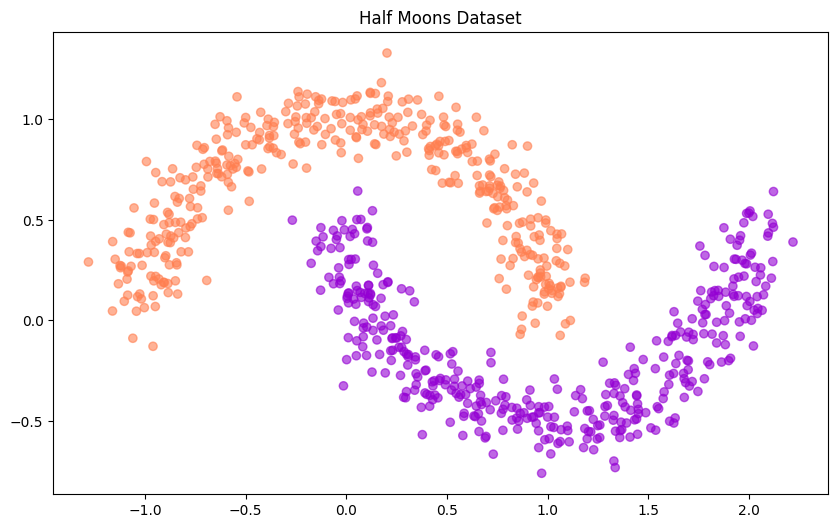

In [39]:
fig, ax = plot_binary_classification_dataset(*data_module.train_set[:], title='Half Moons Dataset')

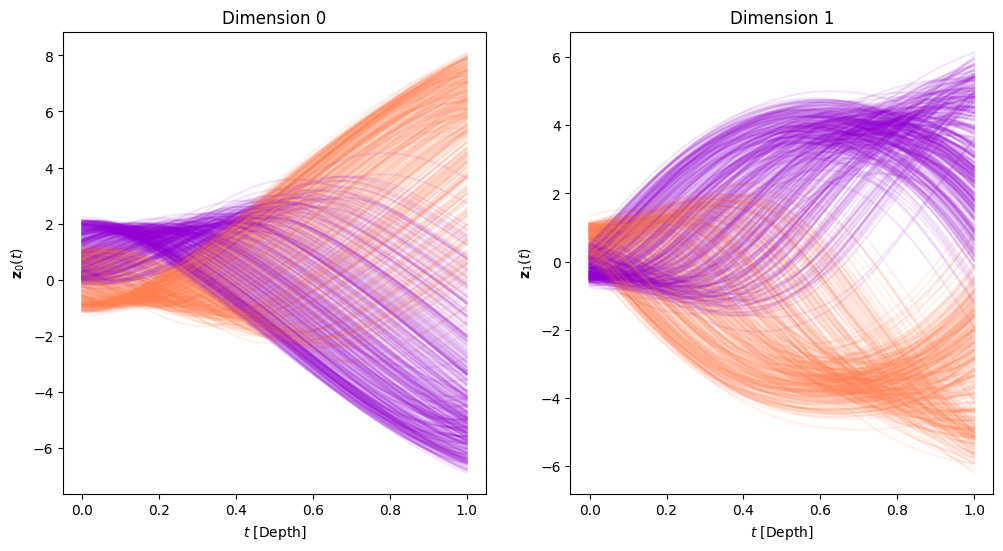

In [40]:
plot_trajectories(time_span, trajectories, class_colors)

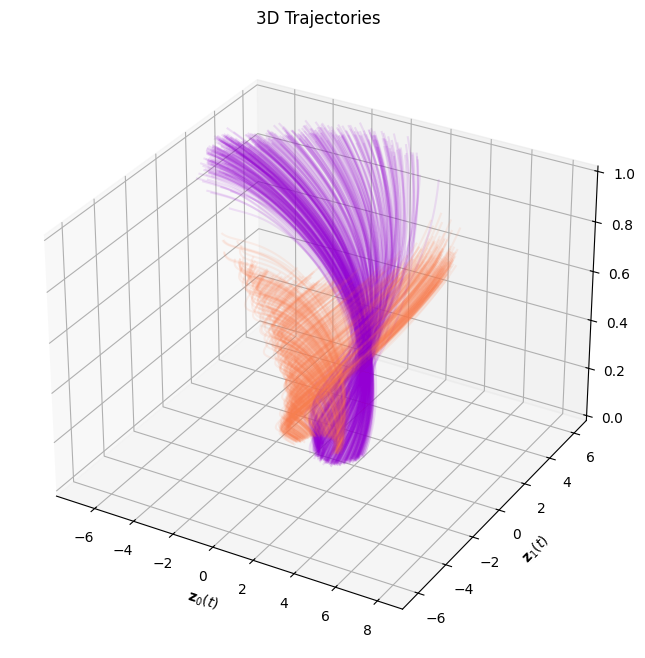

In [41]:
plot_trajectories_3d(time_span, trajectories, class_colors)

In [45]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

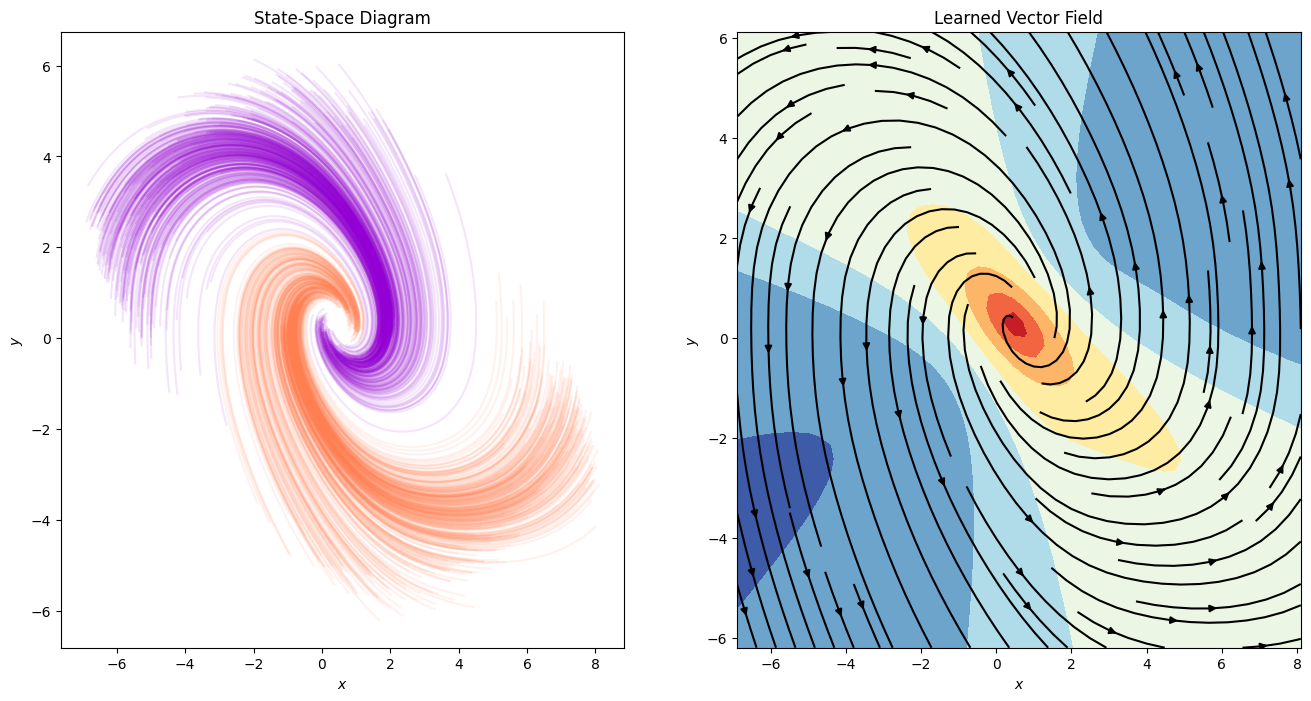

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)                

## Implementation

In [51]:
import os
import math
import numpy as np

from typing import Union, Callable
from IPython.display import clear_output
from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

In [52]:
def ode_solve(z0, t0, t1, 
              f: torch.nn.Module,
              h_max: float = 0.05):
    """
    Solve the ODE z'(t) = f(t, z(t)) with initial condition z(t0) = z0.
    Use RK4 with fixed time step size.
    """
    n_steps = math.ceil((abs(t1 - t0) / h_max).max().item())

    h = (t1 - t0) / n_steps         # Step size that we are using, can be negative

    t = t0
    z = z0

    for _ in range(n_steps):
        k1 = h*f(t, y)
        k2 = h*f(t + h/2, y + k1/2)
        k3 = h*f(t + h/2, y + k2/2)
        k4 = h*f(t + h, y + k3)

        z = z + (k1 + 2*k2 + 2*k3 + k4)/6
        t = t + h

    return z

### Define the augmented dynamics, or the ODE RHS functions

In [50]:
class ODEF(nn.Module):
    """
    A superclass of parameterized dynamics function: f = dz/dt.
    It implements a method that computes the augmented dynamics: f_qug,
    which includes df/dz. df/dp, dp/dt
    """
    def forward(self, *args, **kwargs):
        raise NotImplementedError("Subclass of ODEF must implement this method.")

    def forward_with_grad(self, z, t, grad_outputs):
        """
        Compute f=dz/dt and vJps: a(t) * df/dz, a(t) * df/d params, a(t) * df/dt
        It will be invoked in backward process for adjoint method.
        """
        batch_size = z.shape[0]
        out = self.forward(z, t)    # f = dz/dt

        a = grad_outputs            # \parital L / \partial z(t1)

        # Compute vector Jacobian products (vJps)
        # vJps = a(t) * df/dz, a(t) * df/d params, a(t) * df/dt
        # vJps 是 a 的转置分别与 'out' 相对于 'z', 't', 'parameter' theta 的梯度的点积
        # out 即 f
        # vJps = a^T * d out /dz, a^T * d out /dp + a^T * d out/dt
        # 该方法在一次 backward() 中会被多次调用，因此设置 retain_graph=True
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )

        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            # (1, *)
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            # (batch_size, *)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            # (batch_size, 1)
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp


    def flatten_parameters(self):
        """
        Flatten parameters of the model into a single vector.
        """
        flat_parameters = []
        for p in self.parameters():
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [53]:
class ODEAdjoint(torch.autograd.Function):
    """
    反向传播需要我们自己实现，并且在前向过程中取消梯度
    但是很抱歉，你不能用 torch.nn.Module，因为它的反向传播是由 torch.autograd 自动实现的，
    所以我们要另辟蹊径，用 torch.autograd.Function
    注意其 forward() & backward() 要实现为 staticmethod。
    """
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()

        # 离散时刻 (t0, t1, t2, ...) 的数量
        time_len = t.size(0)

        with torch.no_grad():
            # 已经说了，前向传播不存储梯度
            # 因为 adjoint method 会在自定义的反向传播里通过解反向 ODE 将梯度计算出来
            z = torch.zeros(time_len, bs, *z_shape).to(z0)

            z[0] = z0
            for i_t in range(time_len - 1):
                # 数值求解前向 ODE, 对应所有的时间点
                # z_{t+1} = z_t + \int_{t}^{t+1} f(z_t) dt
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        # ctx, context 上下文用于保存反向传播时需要的一些量
        ctx.func = func
        # 这里 clone() 是避免前向 ODE 解出来的 hidden states 受到外部影响,
        # 因为它们后续要被用作反向 ODE 的初值
        # ps: clone() 返回的 tensor 与原 tensor 不共享内存，也是就两者的修改互不影响,
        # clone 出来的 tensor 本身不会存储梯度, 因其在计算图中不是叶子节点而是中间节点, 但其梯度会叠加到原 tensor 上
        ctx.save_for_backward(t, z.clone(), flat_parameters)

        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        自定义的基于 adjoint 的反向传播
        因为我们考虑了多个离散时间点的情况，所以
        `dLdz` shape: (time_len, batch_size, *z_shape)
        """

        func = ctx.func
        # (time_len, ), (time_len, bs, *z_shape), (n_params,)
        t, z, flat_parameters = ctx.saved_tensors

        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # flatten dL/dz: *z_shape -> n_dim
        dLdz = dLdz.view(time_len, bs, n_dim)

        # Dynamics of augmented system to be calculated backwards in time
        # for each discrete time interval
        def augmented_dynamics(aug_z_i, t_i):
            """
            Compute the dynamics of the augmented system.
            tensors here are temporal slices
            t_i: (1,)
            z_i: (bs, n_dim)
            p_i: (n_param,)
            aug_z_i: (bs, n_dim + n_dim + n_param + 1)
            """
            z_i = aug_z_i[:, :n_dim]
            a = aug_z_i[:, n_dim:2*n_dim]

            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)

            # Compute the dynamics of the augmented system
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)

                # 调用 ODEF 的 forward_with_grad() 方法
                # 进行一次前向计算，得到 f_i = dz_i / dt_i
                # 通过pytorch 自带的 autograd 计算 vJps
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)

                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)


            # Flatten the output
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)

            # NOTE: da(z)/dt = -a(z) * df/dz, da(p)/dt = -a(z) * df/dp, da(t)/dt = -a(z) * df/dt
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        with torch.no_grad():
            # a(z)
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            # a(p)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # a(t), we need to return gradients for all discreted times a(t0), a(t1), ..., a(T)
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            # 依次求解每个离散区间的反向 ODE
            for i_t in range(time_len - 1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # 根据 loss 过来的直接梯度对伴随状态进行调整
                adj_z += dLdz_i

                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # 将 hidden states 以及各伴随状态拼在一起 作为 augmented 状态输入 ODESolver
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)
                aug_ans = ode_solve(aug_z, t_i, t[i_t -1], augmented_dynamics)

                # 从解得的 augmented 状态中分离出各个伴随状态
                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2 * n_dim]
                # Note: we should accumulated sum all discreted adjoints for params
                adj_p[:] += aug_ans[:, 2 * n_dim:(2 * n_dim + n_params)]
                adj_t[i_t - 1] = aug_ans[:, (2 * n_dim + n_params):]

                del aug_z, aug_ans
            
            # 在 t0 时刻也有 loss 过来的直接梯度，于是最后这里也要调整一下
            # dL/dz_{0}
            dLdz_0 = dLdz[0]
            # dL/dt_{0}
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0

        # 输出的数量需要和前向过程中输入的数量对应起来
        # Gradients for each input of forward.
        # dL/dz, dL/dt for all discrete times, dL/dp, None for function call.
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None


In [54]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence: bool=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)

        if return_whole_sequence:
            return z
        else:
            return z[-1]